Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Train")
data_dir_test = pathlib.Path('Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Train",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Train",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

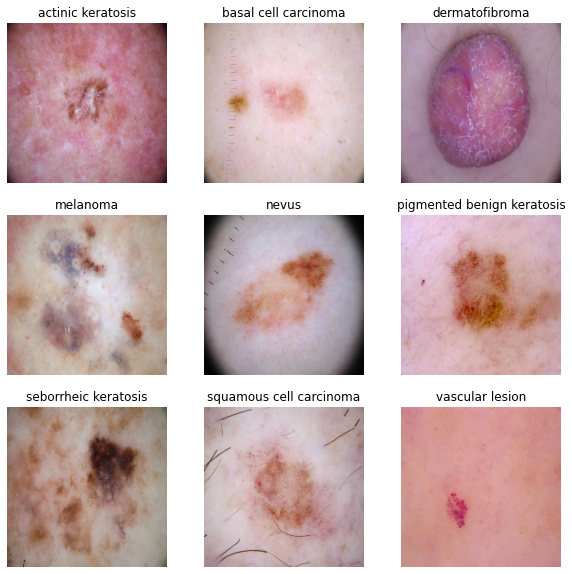

In [9]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
### Your code goes here
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.016232925 0.8394511


In [13]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
    layers.Dense(128, activation='relu'),
     layers.Dense(num_classes)
])
# layers.Dense(128, activation='relu'),

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

### Train the model

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 20s 353ms/step - loss: 2.0127 - accuracy: 0.2478 - val_loss: 1.8204 - val_accuracy: 0.3468
Epoch 2/20
56/56 [==============================] - 15s 264ms/step - loss: 1.7357 - accuracy: 0.3622 - val_loss: 1.5884 - val_accuracy: 0.4452
Epoch 3/20
56/56 [==============================] - 15s 272ms/step - loss: 1.5013 - accuracy: 0.4710 - val_loss: 1.4762 - val_accuracy: 0.5078
Epoch 4/20
56/56 [==============================] - 16s 294ms/step - loss: 1.3313 - accuracy: 0.5318 - val_loss: 1.5201 - val_accuracy: 0.4787
Epoch 5/20
56/56 [==============================] - 17s 297ms/step - loss: 1.2961 - accuracy: 0.5357 - val_loss: 1.3458 - val_accuracy: 0.5257
Epoch 6/20
56/56 [==============================] - 16s 283ms/step - loss: 1.2752 - accuracy: 0.5497 - val_loss: 1.4356 - val_accuracy: 0.5034
Epoch 7/20
56/56 [==============================] - 15s 272ms/step - loss: 1.1744 - accuracy: 0.5837 - val_loss: 1.5376 - val_accuracy: 0.4541

### Visualizing training results

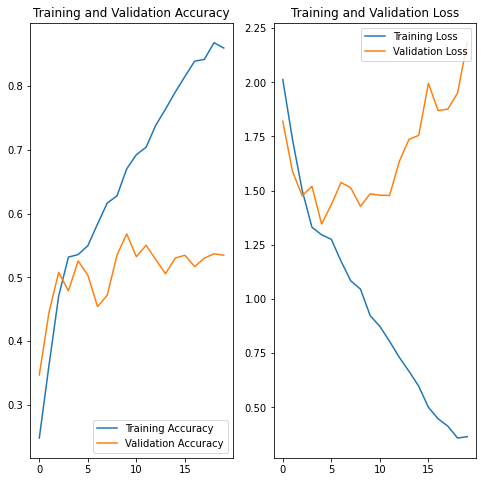

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

### Todo, after you have analysed the model fit history for presence of underfit or overfit, 

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around **55%** in the training process. 

Also, the difference in accuracy between training and validation accuracy is noticeable which is a sign of **overfitting**.

There are multiple ways to fight overfitting in the training process. In our case, I'll use data augmentation and add Dropout to your model.


In [18]:
# Choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

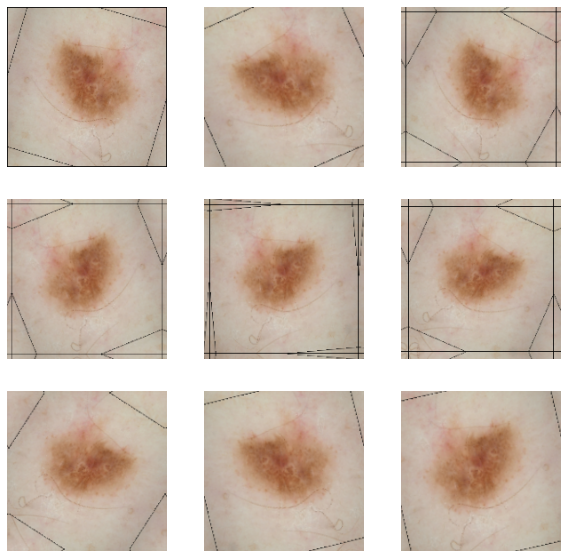

In [19]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [20]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])


### Compiling the model

In [21]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [22]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 18s 318ms/step - loss: 1.9476 - accuracy: 0.2991 - val_loss: 1.7690 - val_accuracy: 0.3378
Epoch 2/20
56/56 [==============================] - 18s 319ms/step - loss: 1.6665 - accuracy: 0.3945 - val_loss: 1.5910 - val_accuracy: 0.4586
Epoch 3/20
56/56 [==============================] - 19s 340ms/step - loss: 1.5242 - accuracy: 0.4777 - val_loss: 1.5270 - val_accuracy: 0.4787
Epoch 4/20
56/56 [==============================] - 19s 344ms/step - loss: 1.4646 - accuracy: 0.4844 - val_loss: 1.4282 - val_accuracy: 0.4966
Epoch 5/20
56/56 [==============================] - 18s 320ms/step - loss: 1.3883 - accuracy: 0.5078 - val_loss: 1.4729 - val_accuracy: 0.4855
Epoch 6/20
56/56 [==============================] - 17s 304ms/step - loss: 1.3977 - accuracy: 0.5145 - val_loss: 1.4881 - val_accuracy: 0.4810
Epoch 7/20
56/56 [==============================] - 17s 300ms/step - loss: 1.3324 - accuracy: 0.5329 - val_loss: 1.3737 - val_accuracy: 0.5548

### Visualizing the results

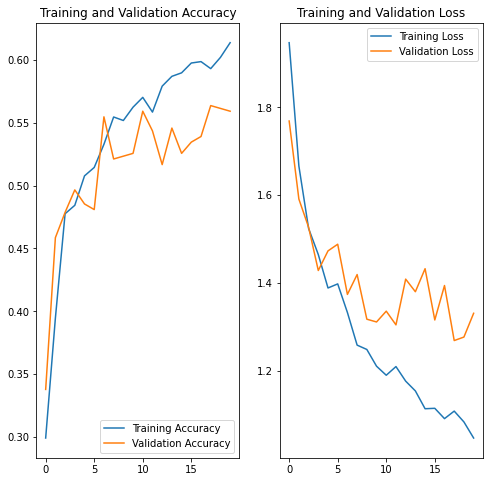

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

After Performing data augumentation strategy and dropout, Now there is very less difference between accuracy of training  and validation data. Similarly the above graph shows more better results than previous one, Thus we can conclude that we sucessfully **removed overfitting issue**. But still we have to increase the accuracy.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [24]:
## Your code goes here.
import fnmatch
classes_details = pd.DataFrame(columns=['Class_Name', 'Quantity'])
for cl in class_names:
    classes_details = classes_details.append(
                {'Class_Name': cl,
                 'Quantity': len(fnmatch.filter(os.listdir('Train/' + cl), '*.jpg'))
                }, ignore_index=True)
print(classes_details.sort_values('Quantity'))

                   Class_Name Quantity
6        seborrheic keratosis       77
2              dermatofibroma       95
0           actinic keratosis      114
8             vascular lesion      139
7     squamous cell carcinoma      181
4                       nevus      357
1        basal cell carcinoma      376
3                    melanoma      438
5  pigmented benign keratosis      462


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
Answer: seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
Answer: pigmented benign keratosis

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [25]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [26]:
path_to_training_dataset="train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF82815B5E0>: 100%|██████████| 500/500 [00:04<00:00, 115.78 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF828044700>:   3%|▎         | 17/500 [00:00<00:25, 19.27 Samples/s]                  

Initialised with 376 image(s) found.
Output directory set to train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF8277118B0>: 100%|██████████| 500/500 [00:03<00:00, 125.54 Samples/s]                  
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF828147790>:   3%|▎         | 13/500 [00:00<00:53,  9.09 Samples/s]                  

Initialised with 95 image(s) found.
Output directory set to train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF8277051C0>: 100%|██████████| 500/500 [00:04<00:00, 117.94 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=722x542 at 0x7FF82812F760>:   0%|          | 2/500 [00:00<00:39, 12.77 Samples/s]           

Initialised with 438 image(s) found.
Output directory set to train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FF8280E7430>: 100%|██████████| 500/500 [00:22<00:00, 22.28 Samples/s]                   
Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FF82817FF70>:   0%|          | 1/500 [00:00<01:29,  5.58 Samples/s]

Initialised with 357 image(s) found.
Output directory set to train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7FF828175EE0>: 100%|██████████| 500/500 [00:16<00:00, 29.50 Samples/s]                    
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF828154130>:   3%|▎         | 14/500 [00:00<00:57,  8.38 Samples/s]                  

Initialised with 462 image(s) found.
Output directory set to train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF8280F52E0>: 100%|██████████| 500/500 [00:04<00:00, 123.54 Samples/s]                  
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FF8280BADF0>: 100%|██████████| 500/500 [00:09<00:00, 50.14 Samples/s]                  
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF8280B0A00>:   2%|▏         | 10/500 [00:00<00:52,  9.32 Samples/s]

Initialised with 181 image(s) found.
Output directory set to train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF828044190>: 100%|██████████| 500/500 [00:04<00:00, 111.92 Samples/s]                  
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF8280BA640>:   2%|▏         | 11/500 [00:00<00:34, 14.16 Samples/s]                 

Initialised with 139 image(s) found.
Output directory set to train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF8280AC910>: 100%|██████████| 500/500 [00:04<00:00, 118.47 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [27]:
data_dir_train = 'Train/'
data_dir_train = pathlib.Path(data_dir_train)
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [28]:
import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Train/melanoma/output/melanoma_original_ISIC_0010313.jpg_24e7e7b2-2a10-4287-bf9f-11491757fb0d.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0009950.jpg_07f9103f-175b-495a-bc53-c1968fdb78ad.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0010965.jpg_879caf11-e8af-45f5-b08b-7cc5b2e0c48c.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0010778.jpg_269cfab9-2a08-4c66-bc63-653c5ef78d42.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0000159.jpg_edd409d4-8396-4f65-b54a-956c0eeaafcd.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0010754.jpg_cbbad564-8b2b-408c-94a7-575b77226163.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0010478.jpg_22c9b8cd-929b-45d6-bfac-fb085d06451f.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0009960.jpg_1e41c23b-99a4-40d4-adab-267025e9c4c5.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0000166.jpg_8815abd4-7fc6-4b5a-8389-69021f3eda26.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0001137.jpg_ffc68efc-5b5e-4a7a-a201

In [29]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [30]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [31]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
# new_df = original_df.append(df2)

In [32]:
df2['Label'].value_counts()

seborrheic keratosis          500
basal cell carcinoma          500
pigmented benign keratosis    500
nevus                         500
vascular lesion               500
squamous cell carcinoma       500
dermatofibroma                500
actinic keratosis             500
melanoma                      500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [33]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [34]:
data_dir_train="Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [35]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [36]:
## your code goes here
model = Sequential([
data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
   layers.Dense(num_classes)
  
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [37]:
## your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


#### **Todo:**  Train your model

In [38]:
epochs = 30
## Your code goes here, use 30 epochs.
# your model fit code
history =  model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 107s 632ms/step - loss: 1.8961 - accuracy: 0.2897 - val_loss: 1.5962 - val_accuracy: 0.3979
Epoch 2/30
169/169 [==============================] - 99s 585ms/step - loss: 1.5272 - accuracy: 0.4232 - val_loss: 1.4185 - val_accuracy: 0.4610
Epoch 3/30
169/169 [==============================] - 99s 587ms/step - loss: 1.4248 - accuracy: 0.4586 - val_loss: 1.2917 - val_accuracy: 0.5041
Epoch 4/30
169/169 [==============================] - 101s 597ms/step - loss: 1.3401 - accuracy: 0.4950 - val_loss: 1.3141 - val_accuracy: 0.5048
Epoch 5/30
169/169 [==============================] - 96s 568ms/step - loss: 1.2530 - accuracy: 0.5198 - val_loss: 1.2369 - val_accuracy: 0.5085
Epoch 6/30
169/169 [==============================] - 922s 5s/step - loss: 1.2268 - accuracy: 0.5362 - val_loss: 1.2632 - val_accuracy: 0.5182
Epoch 7/30
169/169 [==============================] - 99s 584ms/step - loss: 1.1447 - accuracy: 0.5638 - val_loss: 1.1590 - val_ac

#### **Todo:**  Visualize the model results

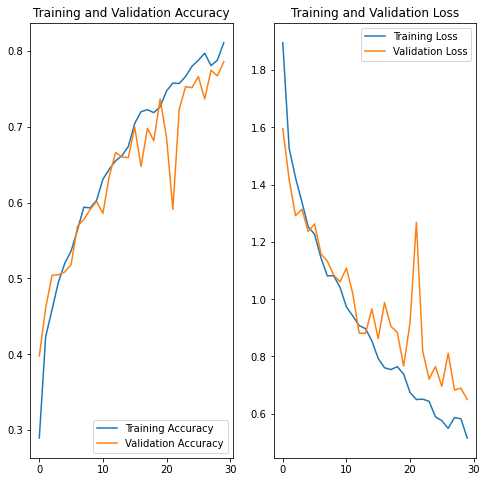

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Now Training Accuracy= **81.06%** and Validation Accuracy = **78.54%**, 

Here we can see that there is not much difference available between Training and validation accuracy. Similarly now both training and validation accuracy linearly increase overt time. Thus we can conclude that we get rid of underfitting/overfitting issue.

Yes, Class rebalance helped a lot to improve both training and validation accuracy by rebalancing the disproportionate ratio of observations in each class which resulting in remove the overfitting issue from the dataset.